In [1]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import json
import matplotlib.pyplot as plt

In [2]:
# Caminhos dos arquivos
file_x_simsim = r"C:\Users\stefa\OneDrive\Documentos\Natali 2\Pristine\SimSim_SOURCE_X_Illustris2_pristine.npy"
file_y_simsim = r"C:\Users\stefa\OneDrive\Documentos\Natali 2\Pristine\SimSim_SOURCE_y_Illustris2_pristine.npy"
file_x_simreal = r"C:\Users\stefa\OneDrive\Documentos\Natali 2\Pristine\SimReal_SOURCE_X_Illustris0.npy"
file_y_simreal = r"C:\Users\stefa\OneDrive\Documentos\Natali 2\Pristine\SimReal_SOURCE_y_Illustris0.npy"

# Carregar os arquivos
X_simsim = np.load(file_x_simsim)
Y_simsim = np.load(file_y_simsim)
X_simreal = np.load(file_x_simreal)
Y_simreal = np.load(file_y_simreal)

In [3]:
# Informações sobre os dados
print("SimSim:")
print(f"X_simsim.shape: {X_simsim.shape}")
print(f"Y_simsim.shape: {Y_simsim.shape}")
print(f"Y_simsim[0]: {Y_simsim[0]}")

print("\nSimReal:")
print(f"X_simreal.shape: {X_simreal.shape}")
print(f"Y_simreal.shape: {Y_simreal.shape}")

SimSim:
X_simsim.shape: (15426, 3, 75, 75)
Y_simsim.shape: (15426,)
Y_simsim[0]: 1.0

SimReal:
X_simreal.shape: (6000, 3, 75, 75)
Y_simreal.shape: (6000,)


In [4]:
# Combinar datasets
print("Combinando datasets")
X = np.concatenate((X_simsim, X_simreal), axis=0)
Y = np.concatenate((Y_simsim, Y_simreal), axis=0)

Combinando datasets


In [5]:
# Embaralhamento dos dados
print("Embaralhamento dos dados")
X, Y = shuffle(X, Y, random_state=42)

Embaralhamento dos dados


In [6]:
# Dividir os dados
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=2/3, random_state=42)

In [7]:
# Normalização e transposição
X_train = X_train.transpose((0, 2, 3, 1)).astype('float32') / 255.0
X_val = X_val.transpose((0, 2, 3, 1)).astype('float32') / 255.0
X_test = X_test.transpose((0, 2, 3, 1)).astype('float32') / 255.0

In [8]:
# Dimensões dos dados
print("Data dimensions: ")
print("Training set: ", np.shape(X_train), np.shape(Y_train))
print("Validation set: ", np.shape(X_val), np.shape(Y_val))
print("Test Set: ", np.shape(X_test), np.shape(Y_test))

Data dimensions: 
Training set:  (14998, 75, 75, 3) (14998,)
Validation set:  (2142, 75, 75, 3) (2142,)
Test Set:  (4286, 75, 75, 3) (4286,)


In [9]:
# Verificação de dados
assert len(X) == len(X_train) + len(X_val) + len(X_test), "Erro: Dados de X não foram preservados!"
assert len(Y) == len(Y_train) + len(Y_val) + len(Y_test), "Erro: Dados de Y não foram preservados!"

In [10]:
# Salvar dados pré-processados
np.save("X_train.npy", X_train)
np.save("Y_train.npy", Y_train)
np.save("X_val.npy", X_val)
np.save("Y_val.npy", Y_val)
np.save("X_test.npy", X_test)
np.save("Y_test.npy", Y_test)

print("Dados pré-processados salvos!")

Dados pré-processados salvos!


In [11]:
# Carregar dados pré-processados
X_train = np.load("X_train.npy")
Y_train = np.load("Y_train.npy")
X_val = np.load("X_val.npy")
Y_val = np.load("Y_val.npy")
X_test = np.load("X_test.npy")
Y_test = np.load("Y_test.npy")

# Imprimir formatos dos dados
print("Formato de X_train:", np.shape(X_train))
print("Formato de Y_train:", np.shape(Y_train))
print("Formato de X_val:", np.shape(X_val))
print("Formato de Y_val:", np.shape(Y_val))
print("Formato de X_test:", np.shape(X_test))
print("Formato de Y_test:", np.shape(Y_test))

Formato de X_train: (14998, 75, 75, 3)
Formato de Y_train: (14998,)
Formato de X_val: (2142, 75, 75, 3)
Formato de Y_val: (2142,)
Formato de X_test: (4286, 75, 75, 3)
Formato de Y_test: (4286,)


In [12]:
# Definir a forma dos dados de entrada
input_shape = np.shape(X_train)[1:]

In [13]:
# Parâmetros de compilação
optimizer = 'adam'
metrics = ['accuracy']
loss = 'binary_crossentropy'

In [25]:
# Criar o modelo
model = Sequential()

# Camadas convolucionais
model.add(Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_last', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
model.add(Dropout(0.2))  # Adicione Dropout após a primeira camada convolucional

model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
model.add(Dropout(0.3))  # Adicione Dropout após a segunda camada convolucional

model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
model.add(Dropout(0.4))  # Adicione Dropout após a terceira camada convolucional

# Camadas densas
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001))) 
model.add(Dropout(0.5)) # Adicione Dropout após a primeira camada densa
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0001))) 
model.add(Dropout(0.5)) # Adicione Dropout após a segunda camada densa

# Camada de saída
model.add(Dense(1, activation='sigmoid'))

In [26]:
# Compilar o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape       ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)        │ (None, 75, 75, 8)  │        608 │
├──────────────────────────┼────────────────────┼────────────┤
│ batch_normalization_6    │ (None, 75, 75, 8)  │         32 │
│ (BatchNormalization)     │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ max_pooling2d_6          │ (None, 38, 38, 8)  │          0 │
│ (MaxPooling2D)           │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout_6 (Dropout)      │ (None, 38, 38, 8)  │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ conv2d_7 (Conv2D)        │ (None, 38, 38, 16) │      1,168 │
├──────────────────────────┼────────────────────┼────────────┤
│ batch_normalization_7    │ (None, 38, 38, 16) │         64 │
│ (BatchNormalization)     │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ max_pooling2d_7          │ (None, 19, 19, 16) │          0 │
│ (MaxPooling2D)           │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout_7 (Dropout)      │ (None, 19, 19, 16) │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ conv2d_8 (Conv2D)        │ (None, 19, 19, 32) │      4,640 │
├──────────────────────────┼────────────────────┼────────────┤
│ batch_normalization_8    │ (None, 19, 19, 32) │        128 │
│ (BatchNormalization)     │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ max_pooling2d_8          │ (None, 10, 10, 32) │          0 │
│ (MaxPooling2D)           │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout_8 (Dropout)      │ (None, 10, 10, 32) │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ flatten_2 (Flatten)      │ (None, 3200)       │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense_3 (Dense)          │ (None, 64)         │    204,864 │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout_9 (Dropout)      │ (None, 64)         │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense_4 (Dense)          │ (None, 32)         │      2,080 │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout_10 (Dropout)     │ (None, 32)         │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense_5 (Dense)          │ (None, 1)          │         33 │
└──────────────────────────┴────────────────────┴────────────┘

 Total params: 213,617 (834.44 KB)

 Trainable params: 213,505 (834.00 KB)

 Non-trainable params: 112 (448.00 B)

In [27]:
# Caminho para salvar checkpoints
checkpoint_filepath = 'melhor_modelo_pesos.weights.h5' 

In [34]:
# Callbacks
checkpoint = ModelCheckpoint(
    filepath='melhor_modelo_pesos.weights.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  
    patience=5,  
    min_lr=1e-05  
)

callbacks = [checkpoint, early_stopping, reduce_lr]  

In [35]:
# Parâmetros de treinamento
batch_size = 32
nb_epoch = 100
shuffle = True

In [36]:
# Treinar o modelo
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=64,
    epochs=50,  
    validation_data=(X_val, Y_val),
    shuffle=True,
    verbose=True,
    callbacks=callbacks
)

Epoch 1/50
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5263 - loss: 0.7109
Epoch 1: val_accuracy improved from -inf to 0.61158, saving model to melhor_modelo_pesos.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.5264 - loss: 0.7109 - val_accuracy: 0.6116 - val_loss: 0.6968 - learning_rate: 0.0010
Epoch 2/50
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5478 - loss: 0.6948
Epoch 2: val_accuracy did not improve from 0.61158
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.5478 - loss: 0.6948 - val_accuracy: 0.5037 - val_loss: 0.7060 - learning_rate: 0.0010
Epoch 3/50
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5769 - loss: 0.6872
Epoch 3: val_accuracy did not improve from 0.61158
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.5769 - loss: 0.6872 - val_accuracy: 0.4753 - val_loss: 0.7163 - learning_rate: 0.0010
Epoch 4/50
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5708 - loss: 0.6840
Epoch 4: val_accuracy

In [37]:
from tensorflow.keras.models import load_model

# Salvar histórico, pesos e modelo
for i in range(10):
    with open(f"history_{i}.json", "w") as f:
        json.dump(history.history, f)

    model.save_weights(f"pesos_modelo_{i}.weights.h5")
    model.save(f"modelo_{i}.keras")

    # Carregar modelo salvo
    loaded_model = load_model(f"modelo_{i}.keras")

    # Criar otimizador rmsprop
    rmsprop = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-07)

    # Compilar o modelo com rmsprop
    loaded_model.compile(
        optimizer=rmsprop,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [38]:
# Imprime o histórico
print(history.history)

{'accuracy': [0.53480464220047, 0.5543406009674072, 0.5800773501396179, 0.5772769451141357, 0.5808107852935791, 0.5876783728599548], 'loss': [0.7072241306304932, 0.6952687501907349, 0.6850992441177368, 0.6826735734939575, 0.6757755875587463, 0.668907105922699], 'val_accuracy': [0.6115779876708984, 0.503734827041626, 0.4752567708492279, 0.5448179244995117, 0.46265172958374023, 0.5522875785827637], 'val_loss': [0.6967971324920654, 0.7060011029243469, 0.7163337469100952, 1.0510003566741943, 0.9337496161460876, 1.0400274991989136], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513]}


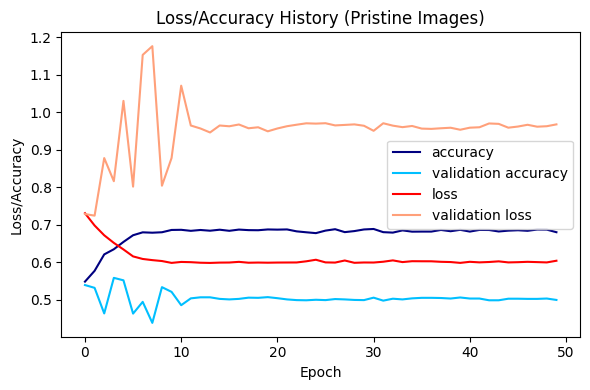

In [39]:
# Plotar histórico
with open("history.json", "r") as f:
    history_data = json.load(f)
    
loss = history_data['loss']
val_loss = history_data['val_loss']
acc = history_data['accuracy']
val_acc = history_data['val_accuracy']

epochs = list(range(len(loss)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")
plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")

plots = plot1_loss + plot1_val_loss + plot1_lacc + plot1_val_lacc
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='center right')

plt.show()